In [1]:
import numpy as np
import pandas as pd
import pysd as pysd #v.3.3.0
import matplotlib.pyplot as plt
import stan_integration as si
from matplotlib import animation
#!pip install -r ../requirements.txt

ModuleNotFoundError: No module named 'pysd'

## Alternating SD and SM in a dynamic manner to decide the best level of safety stock 

### Definition:
####  SD module:
- system dynamics model implemented by Vensim 
- generate data $\tilde{y}$ with fixed latent parameter $\theta$.

#### SM module: 
- statistical model implemented by Stan 
- solving latent parameter $\theta$ that maximizes the likelihood with fixed policy 
- elaboration on policy is needed; explaination of current policy, and other extensions (which will be added in this https://github.com/hyunjimoon/defense-reliability/tree/master/twin/policy_models folder)

#### Research hypothesis: 
- Inventory policy of supply chain supporting the BattleField-RepairShop system can be dynamically decided with a dynamic simulation 

## Goal

Summary: Given a System Dynamics(SD) model which models the entire supply-maintenence network, integrate a 'Policy' (SM, Stan) model which predicts failure count($\hat{y}$) under the current SD model simulation.

---

## Introduction

The SD model defines the supply-maintenence network. The SD model possesses a random distribution which is believed to be the distribution of failure count, under the SD model's assumptions. Performing inference for the underlying distribution is not feasible with the Simulation Dynamics software suite, limiting us from doing much than just drawing from the elementary distribution.

Therefore, we offload the problem of parameter estimation to the SM model, which is a failure distribution (currently) modeled with Stan. The SM model takes draws from SD's failure count distribution as its input. It describes a failure count distribution, of which its parameterization varies depending on what type of model architecture(policy) is being used, such as splines, GPs, etc..

The SM model then can perform estimates on the failure distribution's parameters, as well as calculating predictions for future timeframes($p(y_{t+1}| y_1, y_2, \ldots , y_t)$). The predicted value $y_{t+1}$ can then be used as data for initializing the $t + 1$-time simulation of the SD model.

## Hierarchization

In the current SD and SM model, an assumption of a homogeneous failure distribution is used. In practice, this is rarely the case, as studied through previous research. A complex system like an engine is composed of multiple parts, which undergo different levels of stress and wear. In addition, we can also expect some level of variation between types of engines.

There are two approaches to reflecting the hierarchical nature of equipment. The first approach is to employ a hierarchical model for the SM model, which will then create a unique failure distribution not just for each timeframe, but also per-part and per-engine type. This is relatively trivial to implement, as the spline model curently in use is designed as a hierarchical model.

The second approach is to also run a separate SD model for each group. The assumption here is that each part/engine type will observe different levels of "turnover" through the entire supply-maintenence network, requiring separate modeling. Domain knowledge is needed in justifying this, and whether such a hierarchical SD model can be implemented realistically.

## Expected Benefits of the Vensim-Stan Coupling Process

The Stan PPL excels in performing correct parameter inference for well-defined Bayesian models, which gives us a higher degree of freedom in modeling the failure count distribution as to just using Vensim's internal stat distributions.

This leads to two main benefits. First, failure count, which is a central quantity critical to the accuracy of the entire SD model, can be accurately modeld with an interpretable model. This also allows us to capture the hierarchical nature of the target equipment.

Second, having the SM model "re-perform" inference allows to verify that the estimated distribution matches the original failure count distribution, which assures computation faithfulness. In addition, we can also compare distribution parameters of the inferred distribution $p(\theta | y_t)$ with the original parameter $p(\theta_t)$, much like SBC.

All in all, we believe that the cost estimate of the SD model can be improved through improvements not just within the SD model, but also through a SM model.

In [26]:
mod = pysd.read_vensim('/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/RepairInven.mdl')

![RI.png](RI.png)

There are different types and only 'Auxiliary' can be set as parameter ('Stateful' not tested but no usecase)

In [29]:
set(mod.doc.Type)

{'Auxiliary', 'Constant', None, 'Stateful'}

In [30]:
stocklst = list(mod.doc[mod.doc['Type']=="Stateful"].iloc[:,1])
stocklst
# ['backlog', 'battle_field','demand_forecast','inventory','repair_shop','supply_line']

['backlog',
 'battle_field',
 'demand_forecast',
 'inventory',
 'repair_shop',
 'supply_line']

In [31]:
Auxiliary = list(mod.doc[mod.doc['Type']=="Auxiliary"].iloc[:,1])
Auxiliary

['backlogin',
 'backlogout',
 'cost',
 'deficiency',
 'deficiency_cost',
 'demand',
 'estimated_failure_count',
 'input_1',
 'inventory_adjustment_value',
 'inventory_cost',
 'maintenance',
 'n_of_days_in_stock',
 'natural_failure_count_distribution',
 'predictive_maintenance',
 'purchase_adjustment_value',
 'purchase_amount',
 'purchasing',
 'saveper',
 'shipping',
 'target_inventory',
 'target_supply_line',
 'using']

### Simulation workflow

In [23]:
tot_age = 31
tot_sigma_type = 5
stockCost = [0]*tot_sigma_type
natural_failure_count = np.abs(np.random.normal(40, 10, tot_age))

for sigma in range(1, tot_sigma_type):
    for t in range(tot_age):
        stocks = mod.run(params={'estimated_failure_count': si.fit_failure_simple(natural_failure_count[:t+1])[0], 
                                'n_of_days_in_stock': sigma},
                                 final_time=t)
    print(f"COST at{sigma+1} :", stocks.Cost.iloc[-1, ])
    stockCost[sigma] = stocks.Cost.iloc[-1, ]

00:27:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |████████████████████████████████████████▏           | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 4 |████████████████████████▌               


00:27:24 - cmdstanpy - INFO - CmdStan done processing.
00:27:24 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 244 divergent transitions (24.4%)
	Chain 2 had 112 divergent transitions (11.2%)
	Chain 3 had 97 divergent transitions (9.7%)
	Chain 4 had 299 divergent transitions (29.9%)
	Use function "diagnose()" to see further information.


00:27:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 1 |███▉                                                                                   | 00:00 Status


chain 4 |███▉                                                                                   | 00:00 Status
chain 1 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 3 |███████████████████████████                           | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 4 |██████████████████████████████▋        


00:27:25 - cmdstanpy - INFO - CmdStan done processing.
00:27:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 2 had 17 divergent transitions (1.7%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 9 divergent transitions (0.9%)
	Use function "diagnose()" to see further information.


00:27:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |███████████████████████████████████▍                | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 2 |████████████████████████████████████████▏           | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 4 |██████████████████████████████▋         


00:27:26 - cmdstanpy - INFO - CmdStan done processing.
00:27:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:26 - cmdst

00:27:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█████████████████████████████████                   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 2 |███████████████████████████              

00:27:26 - cmdstanpy - INFO - CmdStan done processing.
00:27:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (1.3%)
	Chain 2 had 4 divergent transitions (0.4%)
	Chain 3 had 7 divergent transitions (0.7%)
	Chain 4 had 15 divergent transitions (1.5%)
	Use function "diagnose()" to see further information.


00:27:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |█████████████████████████████████████▊              | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 3 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 2 |███████████████████████████████████▍     


00:27:27 - cmdstanpy - INFO - CmdStan done processing.
00:27:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:27 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


00:27:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 3 |████████████████████████▌                


00:27:28 - cmdstanpy - INFO - CmdStan done processing.
00:27:28 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use function "diagnose()" to see further information.


00:27:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 3 |███████████████████████████████████▍   


00:27:28 - cmdstanpy - INFO - CmdStan done processing.
00:27:28 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 21 divergent transitions (2.1%)
	Use function "diagnose()" to see further information.


00:27:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |█████████████████████████████████                   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 2 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 3 |█████████████████████████████████        


00:27:29 - cmdstanpy - INFO - CmdStan done processing.
00:27:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 16 divergent transitions (1.6%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.


00:27:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 3 |███████████████████▋                     


00:27:30 - cmdstanpy - INFO - CmdStan done processing.
00:27:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 12 divergent transitions (1.2%)
	Chain 3 had 16 divergent transitions (1.6%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use function "diagnose()" to see further information.


00:27:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████████████████████████                           | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 3 |██████████████████████████████▋          


00:27:30 - cmdstanpy - INFO - CmdStan done processing.
00:27:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 22 divergent transitions (2.2%)
	Chain 2 had 4 divergent transitions (0.4%)
	Chain 3 had 11 divergent transitions (1.1%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


00:27:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 3 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 2 |██████████████████████                   


00:27:31 - cmdstanpy - INFO - CmdStan done processing.
00:27:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyun

00:27:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 2 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 4 |████████████████████████▌               


00:27:32 - cmdstanpy - INFO - CmdStan done processing.
00:27:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 19 divergent transitions (1.9%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 18 divergent transitions (1.8%)
	Use function "diagnose()" to see further information.


00:27:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 4 |███████████████████▋                    

00:27:33 - cmdstanpy - INFO - CmdStan done processing.
00:27:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:33 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (1.3%)
	Chain 2 had 11 divergent transitions (1.1%)
	Chain 3 had 9 divergent transitions (0.9%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


00:27:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 3 |██████████████████████                   


00:27:34 - cmdstanpy - INFO - CmdStan done processing.
00:27:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 7 divergent transitions (0.7%)
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


00:27:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 4 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 3 |████████████████████████▌              


00:27:35 - cmdstanpy - INFO - CmdStan done processing.
00:27:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 52 divergent transitions (5.2%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 22 divergent transitions (2.2%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use function "diagnose()" to see further information.


00:27:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 2 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 4 |█████████████████▏                      


00:27:35 - cmdstanpy - INFO - CmdStan done processing.
00:27:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 34 divergent transitions (3.4%)
	Chain 2 had 54 divergent transitions (5.4%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


00:27:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |█████████████████▏                       


00:27:36 - cmdstanpy - INFO - CmdStan done processing.
00:27:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:36 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 divergent transitions (0.9%)
	Chain 2 had 72 divergent transitions (7.2%)
	Chain 3 had 22 divergent transitions (2.2%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use function "diagnose()" to see further information.


00:27:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████████████████▋                   


00:27:37 - cmdstanpy - INFO - CmdStan done processing.
00:27:37 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 36 divergent transitions (3.6%)
	Chain 2 had 32 divergent transitions (3.2%)
	Chain 3 had 14 divergent transitions (1.4%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.


00:27:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████████████████▋                    


00:27:38 - cmdstanpy - INFO - CmdStan done processing.
00:27:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (1.3%)
	Chain 2 had 355 divergent transitions (35.5%)
	Chain 3 had 8 divergent transitions (0.8%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


00:27:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 3 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |█████████████████▏                     


00:27:39 - cmdstanpy - INFO - CmdStan done processing.
00:27:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 19 divergent transitions (1.9%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 31 divergent transitions (3.1%)
	Chain 4 had 9 divergent transitions (0.9%)
	Use function "diagnose()" to see further information.


00:27:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |███▉                                                                                   | 00:00 Status
chain 1 |███▉                                                                                   | 00:00 Status


chain 4 |███▉                                                                                   | 00:00 Status

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |█████████▊                             

00:27:40 - cmdstanpy - INFO - CmdStan done processing.
00:27:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:40 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 18 divergent transitions (1.8%)
	Chain 2 had 36 divergent transitions (3.6%)
	Chain 3 had 10 divergent transitions (1.0%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use function "diagnose()" to see further information.


00:27:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |█████████████████▏                       


00:27:41 - cmdstanpy - INFO - CmdStan done processing.
00:27:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 14 divergent transitions (1.4%)
	Chain 3 had 6 divergent transitions (0.6%)
	Chain 4 had 27 divergent transitions (2.7%)
	Use function "diagnose()" to see further information.


00:27:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 4 |████████████▎                           


00:27:42 - cmdstanpy - INFO - CmdStan done processing.
00:27:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 6 divergent transitions (0.6%)
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 6 divergent transitions (0.6%)
	Chain 4 had 10 divergent transitions (1.0%)
	Use function "diagnose()" to see further information.


00:27:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████████████▋                         


00:27:43 - cmdstanpy - INFO - CmdStan done processing.
00:27:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 6 divergent transitions (0.6%)
	Chain 2 had 111 divergent transitions (11.1%)
	Chain 3 had 10 divergent transitions (1.0%)
	Chain 4 had 12 divergent transitions (1.2%)
	Use function "diagnose()" to see further information.


00:27:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██████████████▋                        


00:27:45 - cmdstanpy - INFO - CmdStan done processing.
00:27:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 20 divergent transitions (2.0%)
	Chain 3 had 11 divergent transitions (1.1%)
	Chain 4 had 14 divergent transitions (1.4%)
	Use function "diagnose()" to see further information.


00:27:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |██████████████▋                         


00:27:46 - cmdstanpy - INFO - CmdStan done processing.
00:27:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 33 divergent transitions (3.3%)
	Chain 2 had 22 divergent transitions (2.2%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 219 divergent transitions (21.9%)
	Use function "diagnose()" to see further information.


00:27:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                               


00:27:47 - cmdstanpy - INFO - CmdStan done processing.
00:27:47 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 26 divergent transitions (2.6%)
	Chain 2 had 28 divergent transitions (2.8%)
	Chain 3 had 45 divergent transitions (4.5%)
	Chain 4 had 26 divergent transitions (2.6%)
	Use function "diagnose()" to see further information.


00:27:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |██████████████▋                         


00:27:49 - cmdstanpy - INFO - CmdStan done processing.
00:27:49 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 72 divergent transitions (7.2%)
	Chain 2 had 12 divergent transitions (1.2%)
	Chain 3 had 10 divergent transitions (1.0%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use function "diagnose()" to see further information.


00:27:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |██████████████▋                        


00:27:50 - cmdstanpy - INFO - CmdStan done processing.
00:27:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:50 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 15 divergent transitions (1.5%)
	Chain 3 had 23 divergent transitions (2.3%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use func

00:27:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |████████████▎                            


00:27:51 - cmdstanpy - INFO - CmdStan done processing.
00:27:52 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 15 divergent transitions (1.5%)
	Chain 2 had 20 divergent transitions (2.0%)
	Chain 3 had 19 divergent transitions (1.9%)
	Chain 4 had 39 divergent transitions (3.9%)
	Use function "diagnose()" to see further information.


00:27:52 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                               


00:27:53 - cmdstanpy - INFO - CmdStan done processing.
00:27:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 2 had 9 divergent transitions (0.9%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use function "diagnose()" to see further information.



COST at2 : 25903.93856807042


00:27:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████████████████████████████████████████▏           | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 2 |█████████████████████████████████                   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 3 |████████████████████████████████████████▏

00:27:54 - cmdstanpy - INFO - CmdStan done processing.
00:27:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 159 divergent transitions (15.9%)
	Chain 2 had 47 divergent transitions (4.7%)
	Chain 3 had 215 divergent transitions (21.5%)
	Chain 4 had 184 divergent transitions (18.4%)
	Use function "diagnose()" to see further information.
00:27:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 1 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 4 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 2 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 3 |█████████████████████████████████████████████████▋  | 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |███████████████████████████████████████████████████████████████████████████| 00:00 Sampling comp


00:27:54 - cmdstanpy - INFO - CmdStan done processing.
00:27:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 21 divergent transitions (2.1%)
	Chain 2 had 33 divergent transitions (3.3%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 38 divergent transitions (3.8%)
	Use function "diagnose()" to see further information.


00:27:54 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 2 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 3 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 4 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 3 |██████████████████████████████████████████▌         | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |███████████████████████████████████████


00:27:55 - cmdstanpy - INFO - CmdStan done processing.
00:27:55 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 divergent transitions (0.9%)
	Chain 2 had 11 divergent transitions (1.1%)
	Chain 3 had 9 divergent transitions (0.9%)
	Chain 4 had 45 divergent transitions (4.5%)
	Use function "diagnose()" to see further information.
00:27:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████████████████████████████████████████▏           | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 2 |████████████████████████████████████████▏           | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 4 |███████████████████████████████████▍                | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sam


00:27:55 - cmdstanpy - INFO - CmdStan done processing.
00:27:55 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 3 had 12 divergent transitions (1.2%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


00:27:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 2 |█████████████████████████████████████▊              | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 4 |███████████████████████████████████▍    


00:27:56 - cmdstanpy - INFO - CmdStan done processing.
00:27:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 17 divergent transitions (1.7%)
	Chain 2 had 35 divergent transitions (3.5%)
	Chain 3 had 59 divergent transitions (5.9%)
	Use function "diagnose()" to see further information.


00:27:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 3 |███████████████████████████              


00:27:57 - cmdstanpy - INFO - CmdStan done processing.
00:27:57 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 24 divergent transitions (2.4%)
	Chain 2 had 10 divergent transitions (1.0%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 18 divergent transitions (1.8%)
	Use function "diagnose()" to see further information.


00:27:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███████████████████████████                           | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 2 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 3 |███████████████████████████              


00:27:57 - cmdstanpy - INFO - CmdStan done processing.
00:27:57 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 7 divergent transitions (0.7%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 13 divergent transitions (1.3%)
	Chain 4 had 9 divergent transitions (0.9%)
	Use function "diagnose()" to see further information.


00:27:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 3 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |███▉                                                                                   | 00:00 Status
chain 2 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |█████████████████████████████████        


00:27:58 - cmdstanpy - INFO - CmdStan done processing.
00:27:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:27:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 18 divergent transitions (1.8%)
	Chain 2 had 20 divergent transitions (2.0%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use function "diagnose()" to see further information.


00:27:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 3 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 2 |███████████████████▋                     

00:27:59 - cmdstanpy - INFO - CmdStan done processing.
00:27:59 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 1 divergent transitions (0.1%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 23 divergent transitions (2.3%)
	Use function "diagnose()" to see further information.


00:27:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |█████████████████████████████████        


00:27:59 - cmdstanpy - INFO - CmdStan done processing.
00:27:59 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 26 divergent transitions (2.6%)
	Chain 2 had 16 divergent transitions (1.6%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 7 divergent transitions (0.7%)
	Use function "diagnose()" to see further information.


00:28:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |███████████████████████████                           | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 2 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 3 |██████████████████████                   


00:28:00 - cmdstanpy - INFO - CmdStan done processing.
00:28:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 6 divergent transitions (0.6%)
	Chain 2 had 24 divergent transitions (2.4%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.


00:28:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 2 |██████████████████████                   


00:28:01 - cmdstanpy - INFO - CmdStan done processing.
00:28:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 75 divergent transitions (7.5%)
	Use function "diagnose()" to see further information.


00:28:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 3 |█████████████████▏                     


00:28:02 - cmdstanpy - INFO - CmdStan done processing.
00:28:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:02 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 42 divergent transitions (4.2%)
	Chain 2 had 13 divergent transitions (1.3%)
	Chain 3 had 8 divergent transitions (0.8%)
	Chain 4 had 17 divergent transitions (1.7%)
	Use function "diagnose()" to see further information.


00:28:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |███████████████████████████                           | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 4 |████████████████████████▌               


00:28:03 - cmdstanpy - INFO - CmdStan done processing.
00:28:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:03 - cmdstanpy

00:28:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 2 |███████████████████▋                    


00:28:04 - cmdstanpy - INFO - CmdStan done processing.
00:28:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 17 divergent transitions (1.7%)
	Chain 2 had 12 divergent transitions (1.2%)
	Chain 3 had 11 divergent transitions (1.1%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


00:28:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████████████████                  


00:28:05 - cmdstanpy - INFO - CmdStan done processing.
00:28:05 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 31 divergent transitions (3.1%)
	Chain 4 had 68 divergent transitions (6.8%)
	Use function "diagnose()" to see further information.


00:28:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███████████████████▋                    


00:28:06 - cmdstanpy - INFO - CmdStan done processing.
00:28:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 16 divergent transitions (1.6%)
	Chain 2 had 14 divergent transitions (1.4%)
	Chain 3 had 18 divergent transitions (1.8%)
	Chain 4 had 7 divergent transitions (0.7%)
	Use function "diagnose()" to see further information.


00:28:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |██████████████████████                  


00:28:07 - cmdstanpy - INFO - CmdStan done processing.
00:28:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 30 divergent transitions (3.0%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 7 divergent transitions (0.7%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use function "diagnose()" to see further information.


00:28:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███████████████████▋                     


00:28:08 - cmdstanpy - INFO - CmdStan done processing.
00:28:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 20 divergent transitions (2.0%)
	Chain 2 had 65 divergent transitions (6.5%)
	Chain 3 had 20 divergent transitions (2.0%)
	Chain 4 had 39 divergent transitions (3.9%)
	Use function "diagnose()" to see further information.


00:28:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |████████████▎                           


00:28:09 - cmdstanpy - INFO - CmdStan done processing.
00:28:09 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 11 divergent transitions (1.1%)
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use function "diagnose()" to see further information.


00:28:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |█████████████████▏                     


00:28:10 - cmdstanpy - INFO - CmdStan done processing.
00:28:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 18 divergent transitions (1.8%)
	Chain 2 had 17 divergent transitions (1.7%)
	Chain 3 had 12 divergent transitions (1.2%)
	Chain 4 had 27 divergent transitions (2.7%)
	Use function "diagnose()" to see further information.


00:28:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████████████████▏                      


00:28:12 - cmdstanpy - INFO - CmdStan done processing.
00:28:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimo

00:28:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |██████████████▋                         


00:28:13 - cmdstanpy - INFO - CmdStan done processing.
00:28:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 27 divergent transitions (2.7%)
	Chain 2 had 10 divergent transitions (1.0%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 19 divergent transitions (1.9%)
	Use function "diagnose()" to see further information.


00:28:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |██████████████▋                          


00:28:14 - cmdstanpy - INFO - CmdStan done processing.
00:28:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 30 divergent transitions (3.0%)
	Use function "diagnose()" to see further information.


00:28:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██████████████▋                         


00:28:15 - cmdstanpy - INFO - CmdStan done processing.
00:28:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 3 had 6 divergent transitions (0.6%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


00:28:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |████████████▎                          


00:28:17 - cmdstanpy - INFO - CmdStan done processing.
00:28:17 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 20 divergent transitions (2.0%)
	Chain 3 had 19 divergent transitions (1.9%)
	Chain 4 had 28 divergent transitions (2.8%)
	Use function "diagnose()" to see further information.


00:28:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |██████████████▋                        


00:28:18 - cmdstanpy - INFO - CmdStan done processing.
00:28:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 14 divergent transitions (1.4%)
	Chain 2 had 14 divergent transitions (1.4%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use function "diagnose()" to see further information.


00:28:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |██████████████▋                          


00:28:20 - cmdstanpy - INFO - CmdStan done processing.
00:28:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 11 divergent transitions (1.1%)
	Chain 2 had 20 divergent transitions (2.0%)
	Chain 3 had 19 divergent transitions (1.9%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use function "diagnose()" to see further information.


00:28:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |████████████▎                           


00:28:22 - cmdstanpy - INFO - CmdStan done processing.
00:28:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 35 divergent transitions (3.5%)
	Chain 2 had 9 divergent transitions (0.9%)
	Chain 3 had 238 divergent transitions (23.8%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use function "diagnose()" to see further information.


00:28:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |██████████████▋                        


00:28:23 - cmdstanpy - INFO - CmdStan done processing.
00:28:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 6 divergent transitions (0.6%)
	Chain 2 had 4 divergent transitions (0.4%)
	Chain 3 had 17 divergent transitions (1.7%)
	Chain 4 had 42 divergent transitions (4.2%)
	Use function "diagnose()" to see further information.


00:28:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██████████████▋                          


00:28:25 - cmdstanpy - INFO - CmdStan done processing.
00:28:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimo


COST at3 : 24855.667195510585


00:28:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |████████████████████████████████████████████████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 3 |███████████████████████████████████▍                | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 2 |█████████████████████████████████████▊   


00:28:25 - cmdstanpy - INFO - CmdStan done processing.
00:28:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 977 divergent transitions (97.7%)
	Chain 2 had 146 divergent transitions (14.6%)
	Chain 3 had 171 divergent transitions (17.1%)
	Chain 4 had 102 divergent transitions (10.2%)
	Use function "diagnose()" to see further information.


00:28:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |████████████████████████████████████████████▉       | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)
chain 2 |██████████████████████████████████████████▌         | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 3 |███████████████████████████████████▍     


00:28:26 - cmdstanpy - INFO - CmdStan done processing.
00:28:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 26 divergent transitions (2.6%)
	Chain 2 had 16 divergent transitions (1.6%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 16 divergent transitions (1.6%)
	Use function "diagnose()" to see further information.


00:28:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███████████████████████████████████████████████▎    | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 2 |██████████████████████████████████████████▌         | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 4 |████████████████████████████████████████


00:28:26 - cmdstanpy - INFO - CmdStan done processing.
00:28:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 23 divergent transitions (2.3%)
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 16 divergent transitions (1.6%)
	Use function "diagnose()" to see further information.


00:28:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 3 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 2 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 4 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |██████████████████████████████████████████▌         | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 4 |███████████████████████████████████▍    


00:28:27 - cmdstanpy - INFO - CmdStan done processing.
00:28:27 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 8 divergent transitions (0.8%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use function "diagnose()" to see further information.


00:28:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 3 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███████████████████████████████████▍                | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 3 |█████████████████████████████████████▊              | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 2 |█████████████████████████████████████▊   


00:28:28 - cmdstanpy - INFO - CmdStan done processing.
00:28:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:28 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 11 divergent transitions (1.1%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 13 divergent transitions (1.3%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use function "diagnose()" to see further information.


00:28:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |█████████████████████████████████        

00:28:28 - cmdstanpy - INFO - CmdStan done processing.
00:28:28 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 16 divergent transitions (1.6%)
	Chain 2 had 11 divergent transitions (1.1%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


00:28:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |█████████████████████████████████                   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 4 |█████████████████████████████████                   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 3 |██████████████████████████████▋        


00:28:29 - cmdstanpy - INFO - CmdStan done processing.
00:28:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 49 divergent transitions (4.9%)
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 3 had 12 divergent transitions (1.2%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use function "diagnose()" to see further information.


00:28:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |█████████████████████████████████                   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 2 |███████████████████████████████████▍     


00:28:30 - cmdstanpy - INFO - CmdStan done processing.
00:28:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (1.3%)
	Chain 2 had 48 divergent transitions (4.8%)
	Chain 3 had 69 divergent transitions (6.9%)
	Chain 4 had 27 divergent transitions (2.7%)
	Use function "diagnose()" to see further information.


00:28:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |█████████████████████████████████                   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 2 |███████████████████████████              


00:28:30 - cmdstanpy - INFO - CmdStan done processing.
00:28:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 11 divergent transitions (1.1%)
	Chain 3 had 17 divergent transitions (1.7%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


00:28:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |█████████████████████████████▍                        | 00:00 Iteration: 1000 / 2000 [ 50%]  (Warmup)
chain 2 |█████████████████████████████▍                        | 00:00 Iteration: 1000 / 2000 [ 50%]  (Warmup)

chain 3 |█████████████████████████████▍                        | 00:00 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |█████████████████████████████████████████


00:28:31 - cmdstanpy - INFO - CmdStan done processing.
00:28:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:31 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 2 had 10 divergent transitions (1.0%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further information.


00:28:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 2 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 3 |█████████████████▏                       


00:28:32 - cmdstanpy - INFO - CmdStan done processing.
00:28:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 7 divergent transitions (0.7%)
	Chain 2 had 22 divergent transitions (2.2%)
	Chain 3 had 13 divergent transitions (1.3%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use function "diagnose()" to see further information.


00:28:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 4 |██████████████▋                         


00:28:33 - cmdstanpy - INFO - CmdStan done processing.
00:28:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:33 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 14 divergent transitions (1.4%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 6 divergent transitions (0.6%)
	Chain 4 had 7 divergent transitions (0.7%)
	Use function "diagnose()" to see further information.


00:28:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |████████████████████████▌                


00:28:33 - cmdstanpy - INFO - CmdStan done processing.
00:28:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:33 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 17 divergent transitions (1.7%)
	Chain 2 had 23 divergent transitions (2.3%)
	Chain 3 had 9 divergent transitions (0.9%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


00:28:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |███████████████████▋                    


00:28:34 - cmdstanpy - INFO - CmdStan done processing.
00:28:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 2 had 10 divergent transitions (1.0%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 

00:28:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 2 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 3 |██████████████▋                          


00:28:35 - cmdstanpy - INFO - CmdStan done processing.
00:28:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 12 divergent transitions (1.2%)
	Chain 2 had 17 divergent transitions (1.7%)
	Chain 3 had 8 divergent transitions (0.8%)
	Chain 4 had 35 divergent transitions (3.5%)
	Use function "diagnose()" to see further information.


00:28:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |██████████████▋                         


00:28:36 - cmdstanpy - INFO - CmdStan done processing.
00:28:36 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 10 divergent transitions (1.0%)
	Chain 2 had 14 divergent transitions (1.4%)
	Chain 3 had 15 divergent transitions (1.5%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use function "diagnose()" to see further information.


00:28:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███▉                                                                                   | 00:00 Status
chain 2 |███▉                                                                                   | 00:00 Status

chain 3 |███▉                                                                                   | 00:00 Status


chain 4 |███▉                                                                                   | 00:00 Status


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |█████████▊                              


00:28:38 - cmdstanpy - INFO - CmdStan done processing.
00:28:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 18 divergent transitions (1.8%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use function "diagnose()" to see further information.


00:28:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███████████████████▋                    


00:28:39 - cmdstanpy - INFO - CmdStan done processing.
00:28:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


00:28:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |█████████████████▏                      


00:28:40 - cmdstanpy - INFO - CmdStan done processing.
00:28:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:40 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 14 divergent transitions (1.4%)
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 3 had 24 divergent transitions (2.4%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


00:28:40 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 4 |█████████████████▏                     


00:28:41 - cmdstanpy - INFO - CmdStan done processing.
00:28:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 3 had 17 divergent transitions (1.7%)
	Chain 4 had 70 divergent transitions (7.0%)
	Use function "diagnose()" to see further information.


00:28:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |██████████████▋                          


00:28:42 - cmdstanpy - INFO - CmdStan done processing.
00:28:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 15 divergent transitions (1.5%)
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 3 had 12 divergent transitions (1.2%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use function "diagnose()" to see further information.


00:28:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |██████████████▋                        


00:28:43 - cmdstanpy - INFO - CmdStan done processing.
00:28:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 17 divergent transitions (1.7%)
	Chain 3 had 11 divergent transitions (1.1%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


00:28:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |██████████████▋                        


00:28:44 - cmdstanpy - INFO - CmdStan done processing.
00:28:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:44 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


00:28:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |██████████████▋                        


00:28:46 - cmdstanpy - INFO - CmdStan done processing.
00:28:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 20 divergent transitions (2.0%)
	Chain 2 had 25 divergent transitions (2.5%)
	Chain 3 had 9 divergent transitions (0.9%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use function "diagnose()" to see further information.


00:28:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 2 |██████████████▋                         


00:28:47 - cmdstanpy - INFO - CmdStan done processing.
00:28:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:47 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 19 divergent transitions (1.9%)
	Chain 2 had 16 divergent transitions (1.6%)
	Chain 3 had 21 divergent transitions (2.1%)
	Chain 4 had 15 divergent transitions (1.5%)
	Use function "diagnose()" to see further information.


00:28:47 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |██████████████▋                         


00:28:48 - cmdstanpy - INFO - CmdStan done processing.
00:28:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:48 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 27 divergent transitions (2.7%)
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


00:28:48 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |████████████▎                          


00:28:49 - cmdstanpy - INFO - CmdStan done processing.
00:28:49 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 61 divergent transitions (6.1%)
	Chain 2 had 48 divergent transitions (4.8%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 32 divergent transitions (3.2%)
	Use function "diagnose()" to see further information.


00:28:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |█████████▊                             


00:28:51 - cmdstanpy - INFO - CmdStan done processing.
00:28:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 81 divergent transitions (8.1%)
	Chain 2 had 31 divergent transitions (3.1%)
	Chain 3 had 45 divergent transitions (4.5%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


00:28:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |███▉                                                                                   | 00:00 Status

chain 1 |███▉                                                                                   | 00:00 Status
chain 2 |███▉                                                                                   | 00:00 Status


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |████▉                                  


00:28:53 - cmdstanpy - INFO - CmdStan done processing.
00:28:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 divergent transitions (0.9%)
	Chain 2 had 12 divergent transitions (1.2%)
	Chain 3 had 6 divergent transitions (0.6%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


00:28:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                             


00:28:54 - cmdstanpy - INFO - CmdStan done processing.
00:28:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 29 divergent transitions (2.9%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use function "diagnose()" to see further information.


00:28:55 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |███▉                                                                                   | 00:00 Status


chain 1 |███▉                                                                                   | 00:00 Status
chain 2 |███▉                                                                                   | 00:00 Status
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                 


00:28:56 - cmdstanpy - INFO - CmdStan done processing.
00:28:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 59 divergent transitions (5.9%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 33 divergent transitions (3.3%)
	Use function "diagnose()" to see further information.


00:28:56 - cmdstanpy - INFO - CmdStan start processing


COST at4 : 23138.66568511059


chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 3 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 2 |███████████████████████████                           | 00:00 Iteration:  900 / 2000 [ 45%]  (Wa


00:28:57 - cmdstanpy - INFO - CmdStan done processing.
00:28:57 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 109 divergent transitions (10.9%)
	Chain 2 had 242 divergent transitions (24.2%)
	Chain 3 had 120 divergent transitions (12.0%)
	Chain 4 had 137 divergent transitions (13.7%)
	Use function "diagnose()" to see further information.


00:28:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |███████████████████████████████████▍   


00:28:57 - cmdstanpy - INFO - CmdStan done processing.
00:28:57 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 36 divergent transitions (3.6%)
	Chain 2 had 16 divergent transitions (1.6%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.
00:28:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 2 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 4 |██████████████████████████████▋                     | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sam


00:28:58 - cmdstanpy - INFO - CmdStan done processing.
00:28:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 10 divergent transitions (1.0%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 17 divergent transitions (1.7%)
	Use function "diagnose()" to see further information.


00:28:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |█████████████████████████████████                   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 2 |█████████████████████████████████        


00:28:59 - cmdstanpy - INFO - CmdStan done processing.
00:28:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:28:59 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 8 divergent transitions (0.8%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use function "diagnose()" to see further information.


00:28:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 2 |████████████████████████████████████████▏           | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |███████████████████████████████████▍    


00:28:59 - cmdstanpy - INFO - CmdStan done processing.
00:28:59 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 126 divergent transitions (12.6%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 20 divergent transitions (2.0%)
	Use function "diagnose()" to see further information.


00:28:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |███████████████████████████████████▍                | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 2 |█████████████████████████████████████▊   


00:29:00 - cmdstanpy - INFO - CmdStan done processing.
00:29:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 7 divergent transitions (0.7%)
	Chain 2 had 9 divergent transitions (0.9%)
	Chain 3 had 24 divergent transitions (2.4%)
	Chain 4 had 7 divergent transitions (0.7%)
	Use function "diagnose()" to see further information.


00:29:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 2 |███████████████████████████                           | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 3 |███████████████████▋                     


00:29:00 - cmdstanpy - INFO - CmdStan done processing.
00:29:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 14 divergent transitions (1.4%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


00:29:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███████████████████████████                           | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 2 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 3 |██████████████████████████████▋          

00:29:01 - cmdstanpy - INFO - CmdStan done processing.
00:29:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:01 - cmdsta

00:29:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |███████████████████████████                           | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 2 |█████████████████████████████████                   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 4 |████████████████████████▌               


00:29:02 - cmdstanpy - INFO - CmdStan done processing.
00:29:02 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 19 divergent transitions (1.9%)
	Chain 2 had 9 divergent transitions (0.9%)
	Chain 3 had 18 divergent transitions (1.8%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use function "diagnose()" to see further information.


00:29:02 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██████████████████████                                | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 2 |████████████████████████▌                


00:29:03 - cmdstanpy - INFO - CmdStan done processing.
00:29:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 34 divergent transitions (3.4%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 8 divergent transitions (0.8%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use function "diagnose()" to see further information.


00:29:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 2 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |███████████████████████████                           | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 2 |████████████████████████▌                             | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 4 |████████████████████████▌               


00:29:03 - cmdstanpy - INFO - CmdStan done processing.
00:29:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 15 divergent transitions (1.5%)
	Chain 2 had 8 divergent transitions (0.8%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


00:29:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 3 |█████████████████▏                       

00:29:04 - cmdstanpy - INFO - CmdStan done processing.
00:29:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunji

00:29:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 3 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 2 |█████████████████▏                       


00:29:05 - cmdstanpy - INFO - CmdStan done processing.
00:29:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:05 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 9 divergent transitions (0.9%)
	Chain 3 had 7 divergent transitions (0.7%)
	Chain 4 

00:29:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |███████████████████▋                                  | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 4 |█████████████████▏                      


00:29:06 - cmdstanpy - INFO - CmdStan done processing.
00:29:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.8%)
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 12 divergent transitions (1.2%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use function "diagnose()" to see further information.


00:29:07 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |██████████████▋                         

00:29:08 - cmdstanpy - INFO - CmdStan done processing.
00:29:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (1.3%)
	Chain 2 had 13 divergent transitions (1.3%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use function "diagnose()" to see further information.


00:29:08 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |██████████████▋                         


00:29:09 - cmdstanpy - INFO - CmdStan done processing.
00:29:09 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 108 divergent transitions (10.8%)
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 17 divergent transitions (1.7%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use function "diagnose()" to see further information.


00:29:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█████████████████▏                                    | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 2 |█████████████████▏                       


00:29:10 - cmdstanpy - INFO - CmdStan done processing.
00:29:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 14 divergent transitions (1.4%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 17 divergent transitions (1.7%)
	Use function "diagnose()" to see further information.


00:29:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |███▉                                                                                   | 00:00 Status

chain 1 |███▉                                                                                   | 00:00 Status


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |███████▎                                 


00:29:11 - cmdstanpy - INFO - CmdStan done processing.
00:29:12 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 35 divergent transitions (3.5%)
	Chain 3 had 6 divergent transitions (0.6%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


00:29:12 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███████████████████▋                     


00:29:13 - cmdstanpy - INFO - CmdStan done processing.
00:29:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:13 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 21 divergent transitions (2.1%)
	Chain 2 had 34 divergent transitions (3.4%)
	Chain 3 had 6 divergent transitions (0.6%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use function "diagnose()" to see further information.


00:29:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |████████████▎                            


00:29:14 - cmdstanpy - INFO - CmdStan done processing.
00:29:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 11 divergent transitions (1.1%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 4 had 120 divergent transitions (12.0%)
	Use function "diagnose()" to see further information.


00:29:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██████████████▋                          


00:29:15 - cmdstanpy - INFO - CmdStan done processing.
00:29:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 8 divergent transitions (0.8%)
	Chain 3 had 13 divergent transitions (1.3%)
	Chain 4 had 19 divergent transitions (1.9%)
	Use function "diagnose()" to see further information.


00:29:15 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)
chain 1 |██████████████▋                          


00:29:16 - cmdstanpy - INFO - CmdStan done processing.
00:29:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:16 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 25 divergent transitions (2.5%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 7 divergent transitions (0.7%)
	Chain 4 had 12 divergent transitions (1.2%)
	Use function "diagnose()" to see further information.


00:29:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |██████████████▋                          


00:29:18 - cmdstanpy - INFO - CmdStan done processing.
00:29:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 23 divergent transitions (2.3%)
	Chain 3 had 26 divergent transitions (2.6%)
	Chain 4 had 17 divergent transitions (1.7%)
	Use function "diagnose()" to see further information.


00:29:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |██████████████▋                          


00:29:19 - cmdstanpy - INFO - CmdStan done processing.
00:29:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyun

00:29:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 1 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 3 |████████████▎                            


00:29:20 - cmdstanpy - INFO - CmdStan done processing.
00:29:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 42 divergent transitions (4.2%)
	Chain 2 had 3 divergent transitions (0.3%)
	Chain 3 had 11 divergent transitions (1.1%)
	Chain 4 had 14 divergent transitions (1.4%)
	Use function "diagnose()" to see further information.


00:29:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |████████████▎                                         | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |█████████▊                             


00:29:22 - cmdstanpy - INFO - CmdStan done processing.
00:29:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 34 divergent transitions (3.4%)
	Chain 2 had 10 divergent transitions (1.0%)
	Chain 3 had 12 divergent transitions (1.2%)
	Chain 4 had 50 divergent transitions (5.0%)
	Use function "diagnose()" to see further information.


00:29:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 1 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |████████████▎                           


00:29:23 - cmdstanpy - INFO - CmdStan done processing.
00:29:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 16 divergent transitions (1.6%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use function "diagnose()" to see further information.


00:29:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██████████████▋                         


00:29:25 - cmdstanpy - INFO - CmdStan done processing.
00:29:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 31 divergent transitions (3.1%)
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 5 divergent transitions (0.5%)
	Use function "diagnose()" to see further information.


00:29:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██████████████▋                                       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 2 |██████████████▋                         


00:29:26 - cmdstanpy - INFO - CmdStan done processing.
00:29:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 29 divergent transitions (2.9%)
	Use function "diagnose()" to see further information.


00:29:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status

chain 3 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 3 |████████████▎                          


00:29:28 - cmdstanpy - INFO - CmdStan done processing.
00:29:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
	Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/hyunjimoon/Dropbox/code/defense-reliability/twin/policy_models/spline.stan', line 96, column 4 to column 31)
Consider re-running with show_console=True if the above output is unclear!
00:29:28 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 28 divergent transitions (2.8%)
	Chain 2 had 33 divergent transitions (3.3%)
	Chain 3 had 35 divergent transitions (3.5%)
	Chai

00:29:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                       | 00:00 Status
chain 2 |                                                                                       | 00:00 Status

chain 3 |                                                                                       | 00:00 Status


chain 4 |                                                                                       | 00:00 Status
chain 2 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |████▉                                                 | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |███████▎                                              | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 2 |█████████▊                                            | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 4 |█████████▊                              


00:29:30 - cmdstanpy - INFO - CmdStan done processing.
00:29:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 11 divergent transitions (1.1%)
	Chain 2 had 12 divergent transitions (1.2%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 32 divergent transitions (3.2%)
	Use function "diagnose()" to see further information.



COST at5 : 22117.567250344444


<AxesSubplot:>

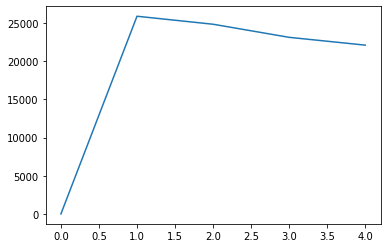

In [24]:
pd.Series(stockCost).plot()

In [25]:
stockCost

[0,
 25903.93856807042,
 24855.667195510585,
 23138.66568511059,
 22117.567250344444]

###  todo
1. compare rate vs count modeling
2. add other engines that constitues one ship (hierarchical)
3. resolve two normal_failure_count generation + extend to time-inhomogeneous